# **Primitives Generator** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1gSx7qym7ePySLI5QNWUy93onEp1_lmBE?usp=sharing)

* primitives are generated for a robot with an *Ackermann Steering Geometry* (approximated with a *Kinematic Bicycle Model*, more info [here](https://www.youtube.com/watch?v=HqNdBiej23I))

* primitives are generated by solving an optimization problem using [Pyomo](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fjckantor.github.io%2FND-Pyomo-Cookbook%2Fnotebooks%2F06.03-Path-Planning-for-a-Simple-Car.html&link_redirector=1) library

* primitives are exported into `.json` format and used in the [Truck](https://github.com/robotics-laboratory/truck) project of the [Robotics Group](https://cs.hse.ru/robotics), HSE University

### Libraries
___

In [1]:
import math
import json
import types
import random
import requests
import numpy as np
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/jckantor/ND-Pyomo-Cookbook/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_ipopt()

from pyomo.environ import *
from pyomo.dae import *

pyomo was previously installed
ipopt was previously installed


### Functions
___

In [2]:
def getYawIndexFromTheta(theta):
  '''
  Snapping a given angle rad to a closest yaw angle rad

  Args:
      theta [double]: angle rad in interval [-min_theta; max_theta)

  Return:
      index [int]: index of a closest yaw angle rad
  '''

  index = round((theta + math.pi) / math.radians(30))
  return index

In [4]:
def dictFromModel(config, m):
  '''
  Convert primitive from a pyomo model to a dictionary

  Args:
      config (L, an_max, v_max, w_max, phi_max, density) [dict]: optimization parameters
      m: pyomo model

  Return:
      primitive (x [array], y [array], theta [array], len, start_yaw_index) [dict]
  '''

  primitive = dict()
  primitive['x'] = [m.x[t]() for t in m.t]
  primitive['y'] = [m.y[t]() for t in m.t]

  poses_count = len(primitive['x'])
  theta = [m.theta[t]() for t in m.t]

  for i in range(poses_count):
    # convert angles rad in interval [-pi; pi]
    theta[i] = math.remainder(theta[i], 2 * math.pi)

    # convert angle rad from pi to -pi
    if theta[i] == math.pi:
      theta[i] = -math.pi

    # check if angles in interval [-pi; pi)
    assert(theta[i] >= config['min_theta'] and theta[i] < config['max_theta'])

  primitive['theta'] = theta

  primitive['len'] = 0.0
  for i in range(1, poses_count):
    primitive['len'] += \
      np.linalg.norm(
          np.array([primitive['x'][i], primitive['y'][i]]) - \
          np.array([primitive['x'][i - 1], primitive['y'][i - 1]])
      )

  # index of a closest yaw to a theta angle from a start pose
  primitive['start_yaw_index'] = getYawIndexFromTheta(primitive['theta'][0])

  return primitive

In [5]:
def buildPrimitive(config, start_pose, end_pose):
  '''
  Solving an optimization problem using pyomo model
  for finding a kinematically executable primitive for a robot

  Args:
      config (L, an_max, v_max, w_max, phi_max, density) [dict]: optimization parameters
      start_pose (x, y, theta) [tuple]: 2D coordinates (x, y) and a theta angle of a first primitive pose
      end_pose (x, y, theta) [tuple]: 2D coordinates (x, y) and a theta angle of an end primitive pose

  Important:
      Changes in (x, y, theta) variables should be calculated relative
      to the middle of the robot's wheelbase (L/2) using these formulas:

        x_dot = v * cos(theta + beta)
        y_dot = v * sin(theta + beta)
        theta_dot = v / L * tan(phi) * cos(beta)

        where beta = atan(0.5 * L * tan(phi))

  Return:
      primitive (x [array], y [array], theta [array], len, start_yaw_index) [dict]
  '''

  # create a model object
  m = ConcreteModel()

  # define the independent variable
  m.tf = Var(domain=NonNegativeReals)
  m.t = ContinuousSet(bounds=(0, 1))

  # define control inputs
  m.w = Var(m.t)

  # define the dependent variables
  m.x = Var(m.t)
  m.y = Var(m.t)
  m.theta = Var(m.t)
  m.phi = Var(m.t, bounds=(-config['phi_max'], +config['phi_max']))

  # define derivatives
  m.x_dot = DerivativeVar(m.x)
  m.y_dot = DerivativeVar(m.y)
  m.theta_dot = DerivativeVar(m.theta)
  m.phi_dot = DerivativeVar(m.phi)

  # define the differential equation as constraints

  @m.Constraint(m.t)
  def ode_x(m, t):
      beta = atan(config['L'] / 2 * tan(m.phi[t]))
      return m.x_dot[t] == (config['v_max'] * cos(m.theta[t] + beta)) * m.tf

  @m.Constraint(m.t)
  def ode_y(m, t):
      beta = atan(config['L'] / 2 * tan(m.phi[t]))
      return m.y_dot[t] == (config['v_max'] * sin(m.theta[t] + beta)) * m.tf

  @m.Constraint(m.t)
  def ode_a(m, t):
      beta = atan(config['L'] / 2 * tan(m.phi[t]))
      return m.theta_dot[t] == (config['v_max'] / config['L'] * tan(m.phi[t]) * cos(beta)) * m.tf

  @m.Constraint(m.t)
  def ode_phi(m, t):
      return m.phi_dot[t] == m.tf * m.w[t]

  m.path_a1 = Constraint(m.t, rule=lambda m, t:  m.w[t] <= + m.tf * config['w_max'])
  m.path_a2 = Constraint(m.t, rule=lambda m, t:  m.w[t] >= - m.tf * config['w_max'])

  m.path_a3 = Constraint(m.t, rule=lambda m, t: config['v_max']**2 * tan(m.phi[t]) <= +config['L'] * config['an_max'])
  m.path_a4 = Constraint(m.t, rule=lambda m, t: config['v_max']**2 * tan(m.phi[t]) >= -config['L'] * config['an_max'])

  # initial conditions
  m.pc = ConstraintList()
  m.pc.add(m.x[0]==start_pose[0])
  m.pc.add(m.y[0]==start_pose[1])
  m.pc.add(m.theta[0]==start_pose[2])

  # initial conditions on the control inputs
  m.pc.add(m.phi[0]==0)
  m.pc.add(m.w[0]==0)

  # final conditions
  m.pc.add(m.x[1.0]==end_pose[0])
  m.pc.add(m.y[1.0]==end_pose[1])
  m.pc.add(m.theta[1.0]==end_pose[2])

  # final conditions on the control inputs
  m.pc.add(m.phi[1.0]==0)
  m.pc.add(m.w[1.0]==0)

  # define the optimization objective
  m.integral = Integral(m.t, wrt=m.t, rule=lambda m, t: (m.w[t]) ** 2)
  m.obj = Objective(expr=m.tf + m.integral)

  # transform and solve
  TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=config['density'])
  SolverFactory('ipopt').solve(m)

  primitive = dictFromModel(config, m)

  return primitive

In [6]:
def buildPrimitivesSet(config, init_poses_arr):
  '''
  Build a set of primitives by a given config and a list of initial poses for a set of primitives

  Args:
      config [dict]: (L, an_max, v_max, w_max, phi_max, density) optimization parameters
      init_poses_arr [list]: list of start and end poses for a set of primitives

  Return:
      primitives [list]: list of primitives
  '''

  primitives = []
  for init_poses in init_poses_arr:
    start_pose = init_poses['start_pose']
    for end_pose in init_poses['end_poses']:
      primitives += [buildPrimitive(config, start_pose, end_pose)]

  return primitives

In [7]:
def drawPrimitivesSet(primitives, style=0, scale=5, s=5, alpha=1.0):
  '''
  Drawing of primitives set in different styles:
    style = 0: curves
    style = 1: points
    style = 2: points with theta angles
  '''

  plt.figure(figsize=(scale, scale))

  for primitive in primitives:
    if style == 0:
      plt.plot(
        primitive['x'],
        primitive['y'],
        alpha=alpha
      )
    elif style == 1:
      plt.scatter(
        primitive['x'],
        primitive['y'],
        s=s,
        alpha=alpha
      )
    elif style == 2:
      plt.quiver(
        primitive['x'],
        primitive['y'],
        np.cos(primitive['theta']),
        np.sin(primitive['theta']),
        color='black',
        scale=25,
        width=0.003,
        alpha=alpha
      )

      plt.scatter(
        primitive['x'],
        primitive['y'],
        s=s,
        alpha=alpha
      )

  plt.xlim([-1, 1])
  plt.ylim([-1, 1])
  plt.grid(True)

### Config
___

Values in `config` are based on [model.yaml](https://github.com/robotics-laboratory/truck/blob/master/packages/model/config/model.yaml) file

In [8]:
config = {
  'L': 0.505,             # car length
  'an_max': 2.0,          # normal acceleration
  'v_max': 0.5,           # fixed vehicle velocity m/s
  'w_max': 3.14,          # max steering velocity rad/s for average servo
  'phi_max': 0.7,         # max steering angle rad
  'density': 20,          # primitive poses count
  'min_theta': -math.pi,  # min car angle rad
  'max_theta': +math.pi,  # max car angle rad
  'yaws_count': 12        # number of yaws angles rad
}

In [9]:
yaw_step = math.radians(360 / config['yaws_count'])
yaws = np.array([config['min_theta'] + (yaw_step * i) for i in range(config['yaws_count'])])

assert(all(yaws >= config['min_theta']) and all(yaws < config['max_theta']))

print('Yaws angles rad:', yaws)

Yaws angles rad: [-3.14159265 -2.61799388 -2.0943951  -1.57079633 -1.04719755 -0.52359878
  0.          0.52359878  1.04719755  1.57079633  2.0943951   2.61799388]


### Generate Primitives Set
___

#### Set #1

In [10]:
init_poses_arr = [
  {
    'start_pose': (0, 0, math.radians(90)),

    'end_poses': [
      (0.0, 0.6, math.radians(90)),
      (-0.2, 0.6, math.radians(90+30)),
      (0.2, 0.6, math.radians(90-30)),
    ]
  },

  {
    'start_pose': (0, 0, math.radians(-90)),

    'end_poses': [
      (0.0, -0.6, math.radians(-90)),
      (0.2, -0.6, math.radians(-90+30)),
      (-0.2, -0.6, math.radians(-90-30)),
    ]
  },

  {
    'start_pose': (0, 0, math.radians(0)),

    'end_poses': [
      (0.6, 0.0, math.radians(0)),
      (0.6, 0.2, math.radians(0+30)),
      (0.6, -0.2, math.radians(0-30)),
    ]
  },

  {
    'start_pose': (0, 0, math.radians(-180)),

    'end_poses': [
      (-0.6, 0.0, math.radians(-180)),
      (-0.6, -0.2, math.radians(-180+30)),
      (-0.6, 0.2, math.radians(-180-30)),
    ]
  },
]

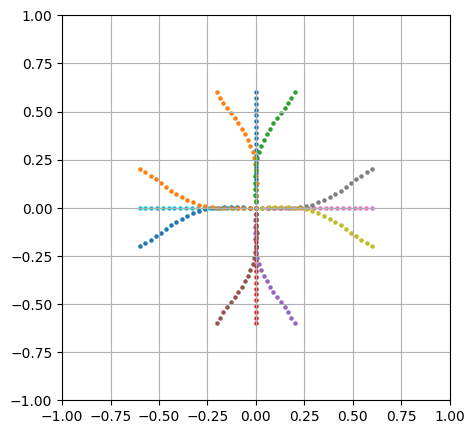

In [11]:
primitives_set_1 = buildPrimitivesSet(config, init_poses_arr)

drawPrimitivesSet(primitives_set_1, style=1, scale=5, s=5, alpha=1.0)

#### Set 2

In [12]:
init_poses_arr = [
  {
    'start_pose': (0, 0, math.radians(60)),

    'end_poses': [
      (0.4, 0.6, math.radians(60)),
      (0.2, 0.8, math.radians(60+30)),
      (0.6, 0.4, math.radians(60-30)),
    ]
  },

  {
    'start_pose': (0, 0, math.radians(-60)),

    'end_poses': [
      (0.4, -0.6, math.radians(-60)),
      (0.6, -0.4, math.radians(-60+30)),
      (0.2, -0.8, math.radians(-60-30)),
    ]
  },

  {
    'start_pose': (0, 0, math.radians(120)),

    'end_poses': [
      (-0.4, 0.6, math.radians(120)),
      (-0.6, 0.4, math.radians(120+30)),
      (-0.2, 0.8, math.radians(120-30)),
    ]
  },

  {
    'start_pose': (0, 0, math.radians(-120)),

    'end_poses': [
      (-0.4, -0.6, math.radians(-120)),
      (-0.2, -0.8, math.radians(-120+30)),
      (-0.6, -0.4, math.radians(-120-30)),
    ]
  },
]

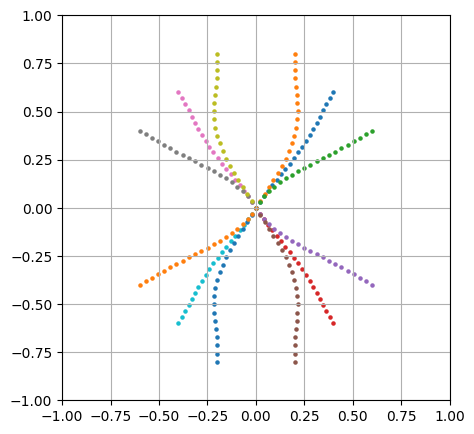

In [13]:
primitives_set_2 = buildPrimitivesSet(config, init_poses_arr)

drawPrimitivesSet(primitives_set_2, style=1, scale=5, s=5, alpha=1.0)

#### Set 3

In [14]:
init_poses_arr = [
  {
    'start_pose': (0, 0, math.radians(30)),

    'end_poses': {
      (0.6, 0.4, math.radians(30)),
      (0.4, 0.6, math.radians(30+30)),
      (0.8, 0.2, math.radians(30-30)),
    }
  },

  {
    'start_pose': (0, 0, math.radians(-30)),

    'end_poses': [
      (0.6, -0.4, math.radians(-30)),
      (0.8, -0.2, math.radians(-30+30)),
      (0.4, -0.6, math.radians(-30-30)),
    ]
  },

  {
    'start_pose': (0, 0, math.radians(-150)),

    'end_poses': [
      (-0.6, -0.4, math.radians(-150)),
      (-0.4, -0.6, math.radians(-150+30)),
      (-0.8, -0.2, math.radians(-150-30)),
    ]
  },

  {
    'start_pose': (0, 0, math.radians(150)),

    'end_poses': [
      (-0.6, 0.4, math.radians(150)),
      (-0.8, 0.2, math.radians(150+30)),
      (-0.4, 0.6, math.radians(150-30)),
    ]
  },
]

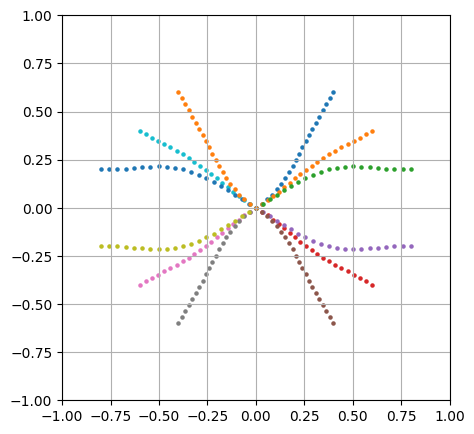

In [15]:
primitives_set_3 = buildPrimitivesSet(config, init_poses_arr)

drawPrimitivesSet(primitives_set_3, style=1, scale=5, s=5, alpha=1.0)

#### Join Sets

Final primitives set is a union of earlier defined sets

In [16]:
primitives = \
  primitives_set_1 + \
  primitives_set_2 + \
  primitives_set_3

In [17]:
len(primitives)

36

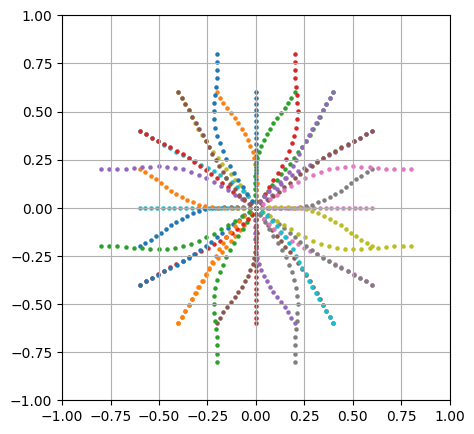

In [18]:
drawPrimitivesSet(primitives, style=1, scale=5, s=5, alpha=1.0)

### Prepare JSON
___

#### Primitives Indexing

* in every primitive we know `start_yaw_index` - index which corresponds to the yaw angle closest to the theta angle from a start pose

* primitives are grouped based on their `start_yaw_index` values in `primitives_indices` array

* this index relation of the corresponding yaws and primitives are stored in `.json` file

In [19]:
primitives_indices = [[] for _ in range(config['yaws_count'])]

for i in range(len(primitives)):
  primitives_indices[primitives[i]['start_yaw_index']] += [i]

print(primitives_indices)

[[9, 10, 11], [30, 31, 32], [21, 22, 23], [3, 4, 5], [15, 16, 17], [27, 28, 29], [6, 7, 8], [24, 25, 26], [12, 13, 14], [0, 1, 2], [18, 19, 20], [33, 34, 35]]


#### Build JSON

In [20]:
json_data = dict()
json_data['primitives_indices'] = primitives_indices
json_data['primitives'] = primitives

file_name = 'primitives'

with open('{0}.json'.format(file_name), 'w') as f:
    json.dump(json_data, f)

JSON Structure:

```json
{
  "primitives_indices": {
    [],
    [],
    ...
  },

  "primitives": [
    {
      "x": [],
      "y": [],
      "theta": [],
      "len": 0.6,
      "start_yaw_index": 10
    },
    {
      ...
    },
    ...
  ]
}
```

___
___